# Compare average beta outputs - Feb 2023 paper

## Purpose of file
1. Import model output and generate means for each beta across each of the 10 runs with the same seeds

2. Use Robbie's function to generate the means for (a) national and (b) district level 

3. Graph the results

## 0. Set up

In [1]:
#%reset # ensures I am starting from scratch when appending dataframes

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pylab as plt
from os.path import isfile, join
from glob import glob

import seaborn as sns
sns.set(style="darkgrid")

In [19]:
#set file paths
path_calib_output = "/Users/sophieayling/Library/CloudStorage/OneDrive-UniversityCollegeLondon/GitHub/Disease-Modelling-SSA/data/output/calibration/50p/"
beta_270 = "/Users/sophieayling/Library/CloudStorage/OneDrive-UniversityCollegeLondon/GitHub/Disease-Modelling-SSA/data/output/calibration/50p/beta_0.270/"
beta_791 = "/Users/sophieayling/Library/CloudStorage/OneDrive-UniversityCollegeLondon/GitHub/Disease-Modelling-SSA/data/output/calibration/50p/beta_0.791/"
plots = "/Users/sophieayling/Library/CloudStorage/OneDrive-UniversityCollegeLondon/GitHub/Disease-Modelling-SSA/data/output/plots/calibration_plots/"
#set input files 
r_dist_tots_deaths_cases = "/Users/sophieayling/Library/CloudStorage/OneDrive-UniversityCollegeLondon/GitHub/Disease-Modelling-SSA/data/preprocessed/line_list/district_tots_deaths_cases.csv"
r_nat_owid = "/Users/sophieayling/Library/CloudStorage/OneDrive-UniversityCollegeLondon/GitHub/Disease-Modelling-SSA/data/preprocessed/line_list/owid-reported_nat_cutdown.csv"
temp = "/Users/sophieayling/Desktop/"

### 1. National comparison graphs
using Robbie's function to generate non-spatial and spatial averages 

In [3]:
def average_output_from_runs_v1(filepath, sample_size):
    # create an empty dataframe to store the output in
    storage_df = pd.DataFrame()
    # Iterate over each file in the filepath
    for file in os.listdir(filepath):
        # read in the data
        data = pd.read_csv(filepath + file, delimiter='\t')
        # drop the unnamed column
        data = data.drop('Unnamed: 10', axis=1)
        # store the output in the dataframe
        storage_df = storage_df.append(data)
    # Calculate the average values of each output by each day
    storage_df = storage_df.groupby('time').mean()
    # Scale the outputs to the population size
    storage_df *= 100 / sample_size
    # Calculate the total number of new cases
    storage_df['new_cases'] = storage_df['metric_new_cases_asympt'] + storage_df['metric_new_cases_sympt']
    # return the averaged outputs
    return storage_df

In [4]:
beta_791_non_spatial = average_output_from_runs_v1(beta_791,50)
beta_791_non_spatial['day']=beta_791_non_spatial.index
beta_791_non_spatial.head()


,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,metric_new_recovered,metric_currently_infected,new_cases,day
time,,,,,,,,,,
0,0.0,0.0,0.0,1.983333,2.016667,0.0,0.0,0.0,4.000000,0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,4.0,0.000000,1
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,4.0,0.000000,2
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,4.0,0.000000,3
4,0.0,0.0,0.0,0.016667,0.041667,0.0,0.0,4.0,0.058333,4


### b. Join OWID case data to national model output

In [5]:
## 2b. Join reported case data to the model output 
#add on the true data 
owid= pd.read_csv(r_nat_owid)
owid.rename(columns={'date':'owid_date'}, inplace=True)
owid.rename(columns={'new_cases':'owid_new_cases'}, inplace=True)
owid.rename(columns={'new_deaths':'owid_new_deaths'}, inplace=True)
owid = owid[['day','owid_date','owid_new_cases', 'owid_new_deaths']]
#make sure they both start on day zero (so change day to index value)
owid['day']=owid.index

owid.head()

,day,owid_date,owid_new_cases,owid_new_deaths
0,0,20/03/2020,1.0,NaN
1,1,21/03/2020,2.0,NaN
2,2,22/03/2020,0.0,NaN
3,3,23/03/2020,0.0,1.0
4,4,24/03/2020,0.0,0.0


In [40]:
#join true and sim data
owid_plus_sim = pd.merge(owid,beta_791_non_spatial, on ='day', how='outer', validate='one_to_one')

# cut down to key vars 
owid_plus_sim = owid_plus_sim[['day', 'owid_date','owid_new_cases', 'new_cases', 'owid_new_deaths', 'metric_new_deaths', 'metric_new_cases_asympt', 'metric_new_cases_sympt' ]]
#only keep where the merge is not missing in the simulation
owid_plus_sim.head()
nat_data = owid_plus_sim[['owid_new_cases', 'new_cases']]
nat_data.head() 

,owid_new_cases,new_cases
0,1.0,4.000000
1,2.0,0.000000
2,0.0,0.000000
3,0.0,0.000000
4,0.0,0.058333


### national level line graph (needs to shift the code below to be subplots)

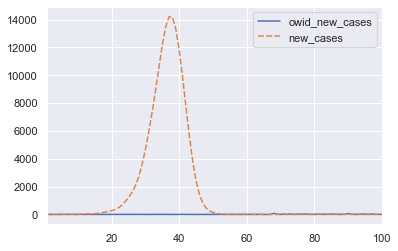

In [44]:
fig,ax = plt.subplots()
sns.lineplot(data=nat_data, ax=ax)
ax.set_xlim(1,100)
plt.show()

## 2. for the spatial model (district level)

In [7]:
def average_output_from_runs_v3(filepath, sample_size):
    # create an empty dataframe to store the output in
    storage_df = pd.DataFrame()
    # Iterate over each file in the filepath
    for file in os.listdir(filepath):
        # read in the data
        data = pd.read_csv(filepath + file, delimiter='\t')
        # drop the unnamed column
        data = data.drop('Unnamed: 10', axis=1)
        # group the estimates from each district by time to get a population level overview
        data = data.groupby(['time', 'myId']).sum()
        # calculate the number of new cases
        data['new_cases'] = data['metric_new_cases_asympt'] + data['metric_new_cases_sympt']
        # store the averaged out metrics in the dataframe
        storage_df = storage_df.append(data)
    # scale estimates to population levels
    storage_df *= 100 / sample_size
    # group averaged out estimates by time
    storage_df = storage_df.groupby(['time', 'myId']).mean()
    # return the dataframe
    return storage_df

### bring in model data (for all betas)

In [26]:
beta_791_spatial = average_output_from_runs_v3(beta_791,50)
beta_791_spatial.reset_index(level=['time', 'myId'], inplace=True)
beta_791_spatial['districtId'] = [int(str(x).split('_')[1]) for x in beta_791_spatial['myId']]
# districtId was added as last column
beta_791_spatial.head()
#just keep output as a copy to check against:
beta_791_spatial.to_csv(temp+'test_791.csv')

#create a district level totals file for lolipops and do multiple betas on one lolipop
beta_791_dist_tots = beta_791_spatial.groupby(['districtId']).agg({'metric_new_cases_sympt': np.sum, 'metric_new_deaths': np.sum})
beta_791_dist_tots.head()
## the metric_new_cases_sympt is just displaying oddly and needs formatting to be wider, but the calculation is correct

,metric_new_cases_sympt,metric_new_deaths
districtId,,
1,3.280993e+05,1123.833333
2,1.026138e+06,2423.666667
3,1.062072e+05,767.000000
4,6.408267e+04,378.833333
5,1.424473e+05,625.833333


,metric_new_cases_sympt,metric_new_deaths
districtId,,
1,3.280993e+05,1123.833333
2,1.026138e+06,2423.666667
3,1.062072e+05,767.000000
4,6.408267e+04,378.833333
5,1.424473e+05,625.833333


### 2b. Join reported case data to district level model output (totals version)

In [10]:
## 2b. Join reported case data to the model output 

#add on the reported data 
moh_dist = pd.read_csv(r_dist_tots_deaths_cases)
moh_dist.head()

moh_dist.rename(columns={'new_district_id':'districtId'}, inplace=True)

moh_dist.rename(columns={'tot_cases_by_district':'moh_cases_by_dist'}, inplace=True)
moh_dist.rename(columns={'tot_deaths_by_district':'moh_deaths_by_dist'}, inplace=True)

moh_dist.head()

,districtId,district_name_shpfile,moh_cases_by_dist,moh_deaths_by_dist
0,1,Bulawayo,1044,26
1,2,Harare,2540,50
2,3,Buhera,20,0
3,4,Chimanimani,14,2
4,5,Chipinge,60,0


In [15]:
#join moh and sim data at district level
dist_moh_plus_sim = pd.merge (moh_dist,beta_791_dist_tots, on = 'districtId', how='outer', validate='one_to_one')
dist_moh_plus_sim = dist_moh_plus_sim[['districtId', 'district_name_shpfile', 'moh_cases_by_dist', 'metric_new_cases_sympt', 'moh_deaths_by_dist', 'metric_new_deaths']]
dist_moh_plus_sim.head()

,districtId,district_name_shpfile,moh_cases_by_dist,metric_new_cases_sympt,moh_deaths_by_dist,metric_new_deaths
0,1,Bulawayo,1044,3.280993e+05,26,1123.833333
1,2,Harare,2540,1.026138e+06,50,2423.666667
2,3,Buhera,20,1.062072e+05,0,767.000000
3,4,Chimanimani,14,6.408267e+04,2,378.833333
4,5,Chipinge,60,1.424473e+05,0,625.833333


### Lolipop plots  (can do this for multiple betas, to see which ones are closer)

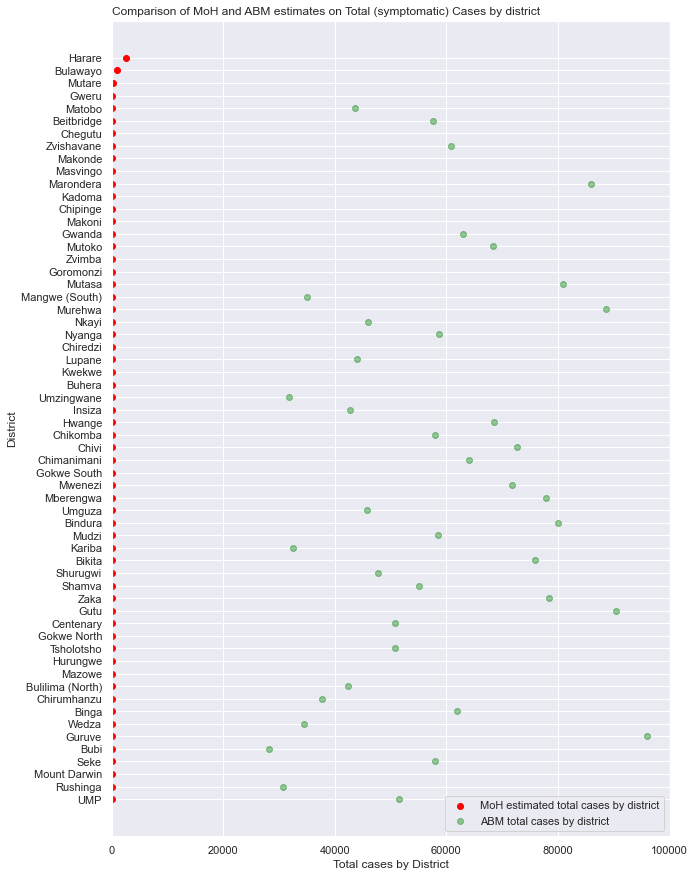

In [29]:
# Reorder it following the values of the first value:
ordered_df = dist_moh_plus_sim.sort_values(by='moh_cases_by_dist')
#ordered_df = dist_true_plus_sim[['districtId', 'true_cases_by_dist', 'sim_tot_cases_dist_med']]

my_range=range(1,len(dist_moh_plus_sim.index)+1)
fig, ax = plt.subplots (figsize = (10, 15))

# The horizontal plot is made using the hline function
#plt.hlines(y=ordered_df['district_name_shpfile'], xmin=ordered_df['true_cases_by_dist'], xmax=ordered_df['sim_tot_cases_dist_med'], color='grey', alpha=0.4)
plt.scatter(ordered_df['moh_cases_by_dist'], my_range, color='red', alpha=1, label='MoH estimated total cases by district')
plt.scatter(ordered_df['metric_new_cases_sympt'], my_range, color='green', alpha=0.4 , label='ABM total cases by district')
plt.legend(loc='lower right')
 
# Add title and axis names
plt.yticks(my_range, ordered_df['district_name_shpfile'])
plt.title("Comparison of MoH and ABM estimates on Total (symptomatic) Cases by district", loc='left')
plt.xlabel('Total cases by District')
plt.ylabel('District')

#limit range on axis
plt.xlim([0, 100000])

# Show the graph
plt.savefig(plots+'lolipop_b791.png')



In [ ]:
# Reorder it following the values of the first value:
ordered_df = dist_true_plus_sim.sort_values(by='true_deaths_by_dist')
#ordered_df = dist_true_plus_sim[['districtId', 'true_cases_by_dist', 'sim_tot_cases_dist_med']]

my_range=range(1,len(dist_true_plus_sim.index)+1)
fig, ax = plt.subplots (figsize = (10, 15))

# The horizontal plot is made using the hline function
#plt.hlines(y=ordered_df['district_name_shpfile'], xmin=ordered_df['true_cases_by_dist'], xmax=ordered_df['sim_tot_cases_dist_med'], color='grey', alpha=0.4)
plt.scatter(ordered_df['true_deaths_by_dist'], my_range, color='red', alpha=1, label='total true deaths by district')
plt.scatter(ordered_df['sim_tot_deaths_dist_med'], my_range, color='green', alpha=0.4 , label='total sim deaths by district')
plt.legend(loc='lower right')
 
# Add title and axis names
plt.yticks(my_range, ordered_df['district_name_shpfile'])
plt.title("Comparison of Sim and True data on Total Deaths by district", loc='left')
plt.xlabel('Total deaths by District')
plt.ylabel('District')

# Show the graph
plt.savefig(path+'plots/district/box_plots/tot_deaths_dists_sim_vs_true.png')



## Make national level graphs with multiple lines

In [ ]:
g = sns.relplot(x="time", y="metric_new_cases_sympt", kind="line", hue="seed", ci=None, data=nat_level).set(title="Case projections of 10 runs - before scaling - 5 perc, 0.3 beta")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_cases_10runs_iccs.png')

In [ ]:
g = sns.relplot(x="time", y="scaled_sim_cases", kind="line", hue="seed", ci=None, data=nat_level).set(title="Case projections of 10 runs - after scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_cases_scaled_10runs.png')

In [ ]:
g = sns.relplot(x="time", y="metric_died_count", kind="line", hue="seed", ci=None, data=nat_level).set(title="Death projections of 10 runs - before scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_deaths_10runs.png')

In [ ]:
g = sns.relplot(x="time", y="scaled_cum_deaths", kind="line", hue="seed", ci=None, data=nat_level).set(title="Death projections of 10 runs - before scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_deaths_scaled_10runs.png')

### Process first case files 

In [ ]:
# keeping only where the number of either symptomatic or asymptomatic is >0
cases = iccs_exports[(iccs_exports.metric_new_cases_sympt > 0) | (iccs_exports.metric_new_cases_asympt > 0)]
cases = cases.drop('\t', axis=1)
cases.head()


In [ ]:
# keep the min time value by district equivalent to first case by district 
first_cases = cases.groupby(['seed','districtId']).agg({'time': 'min'})
first_cases.sort_values(by="time")

# sophie adding want to rename 'time' to denote the day of simulation
first_cases.rename(columns={'time':'simDay_firstcase'}, inplace=True)

#add variables to denote seed of the run, beta value & no. days
files= [first_cases]
for x in files: 
    x ['beta'] = beta
    x ['run_length']= run_length
    x.reset_index(level=['districtId', 'seed'], inplace=True)

# #create a dataframe of this that I can aggregate afterwards
first_cases.to_csv(path_mac_iccs_output_5+'first_cases_10runs.csv')



In [ ]:
# read in the first districts cases data (what she called 'gold standard data')
gold_filename = (path+"../preprocessed/line_list/true.txt")
g_data = pd.read_csv(gold_filename, sep='\t')
g_data["trueDay"] = [int(x) for x in g_data['day']] ## this has just made another variable for the true day which is int format 
g_data.head()

In [ ]:
# m:1 merge on this data (in true/gold data, we have all 60 districts uniquely)
# note the gold data will get replicated across all 10 seeds if works correctly
# join the simulated and gold standard data based on the district ID
iccs_plus_gold = pd.merge (first_cases, g_data, on = 'districtId', how='outer', validate='many_to_one')
iccs_plus_gold.head(20)

# for the true first days for which there are multiple districts, I need to separate them out. e.g. day 1: Harare=1.1 + Buluwayo=1.2

iccs_plus_gold['trueDay_sep']= iccs_plus_gold['day'].astype(str) + '.'+ iccs_plus_gold['districtId'].astype(str)
iccs_plus_gold['trueDay_sep']= iccs_plus_gold['trueDay_sep'].astype(float)
# for i in ema_plus_gold.day:
#     if i.find([''])

iccs_plus_gold= iccs_plus_gold[['districtId', 'district_name_shpfile',  'trueDay_sep','trueDay','simDay_firstcase', 'seed', 'beta', 'run_length' ]]  #'trueDay_sep',
iccs_plus_gold.to_csv(path_mac_iccs_output_5+'iccs_plus_gold.csv')
iccs_plus_gold.head()

## Box plotting the district level comparisons 

In [ ]:
fig, ax = plt.subplots (figsize = (15, 15))
ax = sns.boxplot(
                x='trueDay_sep', 
                y='simDay_firstcase',
                data=iccs_plus_gold)
ax.axes.set_title("Box Plot of First Day cases of Simulated vs. True data across seeds", fontsize=16)
ax.set_xlabel("True Day first cases. District Number", fontsize=14)
ax.set_ylabel("Simulation Day first cases", fontsize=14)


# make sure x axis labels are visible
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, size = 10)
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
        
from matplotlib.ticker import FormatStrFormatter
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
#put on same scale
# ax.set(xlim=(0, 179), ylim=(0, 179)) # in true day the max first day is 136, in sim the max first day is 179
# xl, yl = [0,179], [0,179]
# sns.lineplot(xl, yl, linestyle='--', color='red')

# Be sure to only pick integer tick locations.
# import matplotlib.ticker as ticker

# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig(path+'plots/district/box_plots/first_cases_dist_10seeds_016_180_incl_asympt.png')
# Nice example code here https://stackabuse.com/seaborn-box-plot-tutorial-and-examples/

In [ ]:
## Do the plots with margins 
